# Stats Tests

The purpose of this notebook is to look into statistical significance, hypothesis tests, and tests to verify that the empirical distributions match or don't match the theoretical distributions I see these variables as.

In this notebook I'll perform the following:

1. A little more EDA as needed and data cleaning that results from that

2. Joining the region IDs and filtering down as I've done for the master DF

3. Bootstrap resampling on various discrete and continuous variables to see that my samples reasonably came from the population.

4. Bayesian tests as necessary.

### 1. EDA/Cleaning and 2. Region ID merging

In [1]:
# some manipulations happened in EDA Part I so I'm loading in an updated dev_df.

import pandas as pd, numpy as np

dev_df = pd.read_csv('C:/Users/riley/Documents/Coding/DSC/lyft_no_data/dev_df_post_EDA_cleaning.csv')

In [2]:
# joining the regions df so that I can filter by SF region

regions = pd.read_csv('C:/Users/riley/Documents/Coding/DSC/lyft_no_data/region_ids.csv')

dev_df = pd.merge(dev_df, regions, 'inner', left_on='start_station_id', right_on='station_id')

In [3]:
# filter by SF region

dev_df = dev_df[dev_df['region_id'] == 3]

In [4]:
# Get revenue by station

station_revenue = dev_df.pivot_table(values='cost_to_ride', columns='start_station_id', aggfunc='sum').melt()

In [5]:
station_revenue['total_value_of_station'] = station_revenue['value']

In [6]:
station_revenue.drop('value', axis=1, inplace=True)

In [7]:
dev_df = dev_df.merge(station_revenue, 'inner', left_on='start_station_id', right_on='total_value_of_station')

In [8]:
cols_to_keep = [
       'start_station_latitude', 'start_station_longitude', 'duration_min', 'start_time', 'end_time',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'age', 'member_gender', 'station_id', 'total_value_of_station', 'cost_to_ride']

# final df minus unnecessary columns

dev_df = dev_df[cols_to_keep]

In [44]:
from sklearn.utils import resample

# making necessary bootstrap functions to use over and over

def bootstrap_sample(var, func=np.mean, repetitions=10000, conf_interval=[2.5, 97.5]):
    test_stat = func(var)
    
    var_name = str(var)
    func_name = str(func)
    
    repetitions = repetitions
    
    variables = np.empty(repetitions)
    
    for i in range(repetitions):
        variables[i] = func(resample(var, n_samples = repetitions))
    
    lower_conf, upper_conf = np.percentile(variables, conf_interval)

    return print(f"Test stat = {test_stat}"), print('\n'), print(f"Confidence interval is between {lower_conf} and {upper_conf}"), plt.hist(variables), plt.title("Bootstrap resample of test stat"), plt.xlabel("Possible test stat values"), plt.ylabel("Count")#, plt.axvline(test_stat, color='y'), plt.axvline(conf_interval[0], color='y', linestyle='--'), plt.axvline(conf_interval[1], color='y', linestyle='--'), plt.show()

### 3. Bootstrap Resampling

Test stat = 13.912412350842661


Confidence interval is between 13.0022775 and 14.9070575


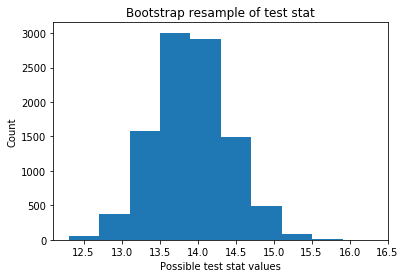

In [45]:
# duration of rides
bootstrap_sample(dev_df.duration_min, repetitions=10000);

Test stat = 37.606347644236685


Confidence interval is between 37.4238 and 37.7926025


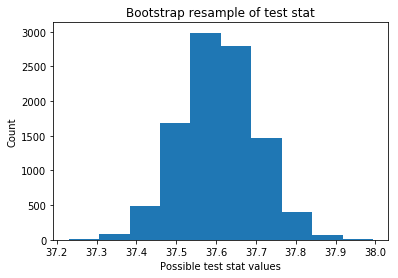

In [258]:
# mean age
bootstrap_sample(dev_df.age);

Test stat = 0.8569319719522697


Confidence interval is between 0.6771975 and 1.0527075


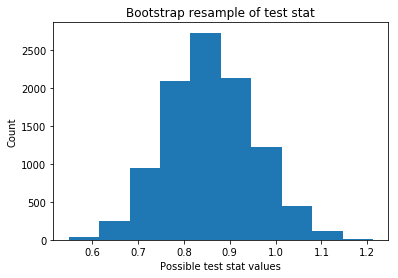

In [259]:
bootstrap_sample(dev_df.cost_to_ride);

### Bootstrap Resampling of standard deviation differences
Checking the difference between subscriber and customer cost of ride standard deviations

In [14]:
def std_diff(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of std of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

def permute_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2)) # tuple

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_samp_1 = permuted_data[:len(data1)]
    perm_samp_2 = permuted_data[len(data1):]

    return perm_samp_1, perm_samp_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_samp_1, perm_samp_2 = permute_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_samp_1, perm_samp_2)

    return perm_replicates

In [24]:
# split the data up by subscriber and customer
subscribers = dev_df[dev_df['user_type'] == 'Subscriber'].cost_to_ride
customers = dev_df[dev_df['user_type'] == 'Customer'].cost_to_ride

subscribers_std = np.std(subscribers)
customers_std = np.std(customers)

print(f'std for subscribers = {subscribers_std}, std for customers = {customers_std}')

std for subscribers = 3.437848023517044, std for customers = 26.738137912657415


In [25]:
np.random.seed(47)
N_rep = 10000
 
bs_sample_std_diff = np.empty(N_rep)    
 
# Generate bootstrap sample: bs_sample
bs_sample_std_diff = draw_perm_reps(subscribers, customers, std_diff, N_rep)

Standard deviation mean diff: 0.7488544815724765
95% percentile: lower -7.033363287326461, upper 7.975062033945086


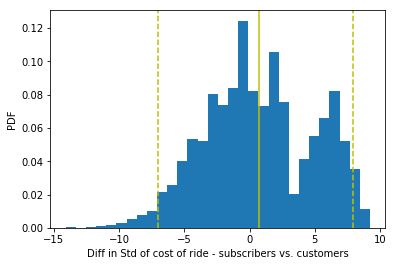

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

bs_sample_std_diff = np.sort(bs_sample_std_diff)
bs_sample_std_mean = np.mean(bs_sample_std_diff)

bs_sample_std_perc_95 = np.percentile(bs_sample_std_diff, [2.5, 97.5])
print('Standard deviation mean diff: ' + str(bs_sample_std_mean))
print('95% percentile: lower ' + str(bs_sample_std_perc_95[0]) + ', upper ' + str(bs_sample_std_perc_95[1]))
_ = plt.hist(bs_sample_std_diff, bins=30, normed=True)
_ = plt.xlabel('Diff in Std of cost of ride - subscribers vs. customers')
_ = plt.ylabel('PDF')
_ = plt.axvline(bs_sample_std_mean, color='y')
_ = plt.axvline(bs_sample_std_perc_95[0], color='y', linestyle='--') 
_ = plt.axvline(bs_sample_std_perc_95[1], color='y', linestyle='--') 
plt.show()

H0 = there is a difference between the standard deviations of cost to ride for customers vs. subscribers
H1 = there is no difference between the standard deviations of cost to ride for customers vs. subscribers

95% confidence interval is -7 to 7.97 standard deviation, so we lack sufficient evidence to state H0 that there is a difference, and thus reject the null hypothesis, meaning that the mean standard deviation of the cost to ride for customers and subscribers is within the confidence interval range and thus is unlikely to have been observed by random chance. 